In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib as mpl
import BiGLasso_Methods as bg
import GmGM
import scipy.stats as stats
import scipy.sparse as sparse
import igraph as ig

import os

In [4]:
# Load data
# Get all types of objects
data_dir = 'data/coil-20-proc/'
headers = {x.split('__')[0] for x in os.listdir(data_dir)}
print(headers)

{'obj11', 'obj16', 'obj4', 'obj8', 'obj3', 'obj19', 'obj18', 'obj10', 'obj15', 'obj14', 'obj6', 'obj9', 'obj1', 'obj12', 'obj17', 'obj2', 'obj7', 'obj20', 'obj13', 'obj5'}


In [5]:
# Every object has 72 frames, with 128x128 pixels
data: dict[str, np.ndarray] = {}
for object in headers:
    # Get all images of the object
    images = [x for x in os.listdir(data_dir) if x.split('__')[0] == object]
    frame_numbers = [int(x.split('__')[1].split('.')[0]) for x in images]
    data[object] = np.ndarray((len(images), 128, 128))
    for i, image in zip(frame_numbers, images):
        data[object][i] = plt.imread(data_dir + image)

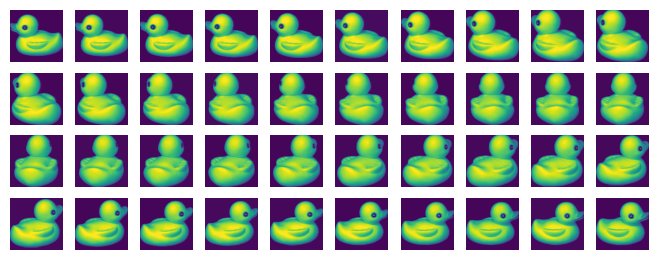

In [6]:
fig, axs = plt.subplots(ncols=10, nrows=4)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data['obj1'][i])
    ax.axis('off')
# lower remove margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.5)

In [179]:
dataset = GmGM.Dataset(
    dataset=data,
    structure={
        object: (f'frame', f'{object}_row', f'{object}_column')
        for object in headers
    },
    batch_axes=None
)

In [180]:
# Keep all edges, and postprocess for statistical significance later, so we can peek around
results = GmGM.GmGM(
    dataset,
    to_keep=0.05, # 5-sigma
    threshold_method="bonferroni",
    n_comps=128,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
)
results

Centering...
Calculating eigenvectors...
	by calculating left eigenvectors of concatenated matricizations...
		Explained variance for axis='obj14_row': 100.0000%
		Explained variance for axis='obj18_column': 100.0000%
		Explained variance for axis='obj1_column': 100.0000%
		Explained variance for axis='obj7_row': 100.0000%
		Explained variance for axis='obj10_column': 100.0000%
		Explained variance for axis='obj20_column': 100.0000%
		Explained variance for axis='obj2_row': 100.0000%
		Explained variance for axis='obj16_row': 100.0000%
		Explained variance for axis='obj13_row': 100.0000%
		Explained variance for axis='obj3_column': 100.0000%
		Explained variance for axis='obj1_row': 100.0000%
		Explained variance for axis='obj13_column': 100.0000%
		Explained variance for axis='obj15_column': 100.0000%
		Explained variance for axis='obj20_row': 100.0000%
		Explained variance for axis='obj8_row': 100.0000%
		Explained variance for axis='obj11_row': 100.0000%
		Explained variance for axi

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset(
	obj11: ('frame', 'obj11_row', 'obj11_column')
	obj16: ('frame', 'obj16_row', 'obj16_column')
	obj4: ('frame', 'obj4_row', 'obj4_column')
	obj8: ('frame', 'obj8_row', 'obj8_column')
	obj3: ('frame', 'obj3_row', 'obj3_column')
	obj19: ('frame', 'obj19_row', 'obj19_column')
	obj18: ('frame', 'obj18_row', 'obj18_column')
	obj10: ('frame', 'obj10_row', 'obj10_column')
	obj15: ('frame', 'obj15_row', 'obj15_column')
	obj14: ('frame', 'obj14_row', 'obj14_column')
	obj6: ('frame', 'obj6_row', 'obj6_column')
	obj9: ('frame', 'obj9_row', 'obj9_column')
	obj1: ('frame', 'obj1_row', 'obj1_column')
	obj12: ('frame', 'obj12_row', 'obj12_column')
	obj17: ('frame', 'obj17_row', 'obj17_column')
	obj2: ('frame', 'obj2_row', 'obj2_column')
	obj7: ('frame', 'obj7_row', 'obj7_column')
	obj20: ('frame', 'obj20_row', 'obj20_column')
	obj13: ('frame', 'obj13_row', 'obj13_column')
	obj5: ('frame', 'obj5_row', 'obj5_column')
)
Axes(
	obj14_row: 128
		Prior: None
		Gram: Not calculated
		Eig: Calculated

In [ ]:
# To test statistical significance here, we have the following coefficients:
# Row and column axes: d_\ℓ is 128*72 = 9216, σ^γ = 1/sqrt(3), summed over the 20 objects
#   = sqrt(20*9216) / 3 = 47.7 * 3
#   Bonferroni correction: (128^2 - 128) / 2 = 8128
# Frame axes: d_\ℓ is 128*128, σ^γ = 1/sqrt(3), summed over the 20 objects
#   = sqrt(20*128*128) / 3 = 63.6 * 3
#   Bonferroni correction: (72^2 - 72) / 2 = 2556

# Frames
offdiags = results.precision_matrices['frame'].toarray()[np.triu_indices(72, 1)]
print((1 - stats.norm.cdf(3 * 63.6 * offdiags)).min())

# Rows/columns
offdiags = results.precision_matrices['obj1_row'].toarray()[np.triu_indices(72, 1)]
print((1 - stats.norm.cdf(3 * 47.7 * offdiags)).min())
offdiags = results.precision_matrices['obj1_column'].toarray()[np.triu_indices(72, 1)]
print((1 - stats.norm.cdf(3 * 47.7 * offdiags)).min())

0.0
0.5
0.5


In [ ]:
# About 2% of columns are significant
((8128 * (1 - stats.norm.cdf(3 * 47.7 * offdiags))) < 0.05).sum() / offdiags.shape[0]

0.0

In [ ]:
display(
    stats.norm.ppf(1 - 0.00006 / (72**2 - 72)) / (63.6 * 3),
    stats.norm.ppf(1 - 0.00006 / (72**2 - 72)),
    (72**2 - 72) / 2,
    0.05 / ((72**2 - 72) / 2)
)

0.029267437697118624

5.584227112610233

2556.0

1.9561815336463226e-05

In [181]:
resmatrix = results.precision_matrices['frame'].toarray()
#resmatrix[resmatrix < stats.norm.ppf(1 - 0.05 / 8128) / 47.7] = 0
#resmatrix[resmatrix < stats.norm.ppf(1 - 0.00003 / (72**2 - 72)) / (63.6 * 3)] = 0
resmatrix[:10, :10]

array([[0.        , 0.06846713, 0.05762854, 0.04321598, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06846713, 0.        , 0.0678368 , 0.05618294, 0.04337731,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.05762854, 0.0678368 , 0.        , 0.07014131, 0.05644306,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.04321598, 0.05618294, 0.07014131, 0.        , 0.07068597,
        0.05413998, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.04337731, 0.05644306, 0.07068597, 0.        ,
        0.06104847, 0.05427059, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.05413998, 0.06104847,
        0.        , 0.05875107, 0.04685664, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.05427059,
        0.05875107, 0.        , 0.06065539, 0.04713624, 0.        ],
       [0.        , 0.        , 0.       

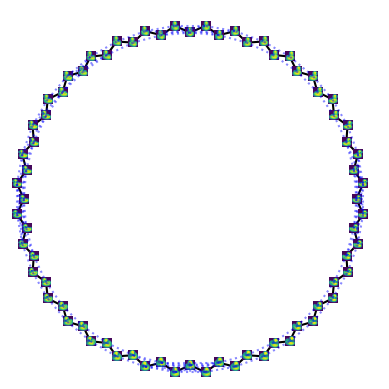

In [182]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/gmgm-full.pdf', transparent=True, dpi=200)

In [183]:
correct__1 = 0
off_by_1__1 = 0
off_by_2__1 = 0
off_by_3__1 = 0
off_by_more__1 = 0
total__1 = 0

for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix[i, j] != 0:
            total__1 += 1
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                correct__1 += 1
            elif np.abs(i - j) == 2 or np.abs(i - j) == 70:
                off_by_1__1 += 1
            elif np.abs(i - j) == 3 or np.abs(i - j) == 69:
                off_by_2__1 += 1
            elif np.abs(i - j) == 4 or np.abs(i - j) == 68:
                off_by_3__1 += 1
            else:
                off_by_more__1 += 1
correct__1, off_by_1__1, off_by_2__1, off_by_3__1, off_by_more__1, total__1

(72, 72, 25, 4, 0, 173)

In [184]:
# Keep all edges, and postprocess for statistical significance later, so we can peek around
dataset2 = GmGM.Dataset(
    dataset=data,
    structure={
        object: (f'frame', f'{object}_row', f'{object}_column')
        for object in headers
    },
    batch_axes=None
)
results2 = GmGM.GmGM(
    dataset2,
    to_keep=0.05,
    threshold_method="bonferroni",
    n_comps=10,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
)
results2

Centering...
Calculating eigenvectors...
	by calculating left eigenvectors of concatenated matricizations...
		Explained variance for axis='obj14_row': 86.9173%
		Explained variance for axis='obj18_column': 87.3932%
		Explained variance for axis='obj1_column': 93.4585%
		Explained variance for axis='obj7_row': 87.1975%
		Explained variance for axis='obj10_column': 92.6083%
		Explained variance for axis='obj20_column': 85.5907%
		Explained variance for axis='obj2_row': 87.0246%
		Explained variance for axis='obj16_row': 95.7596%
		Explained variance for axis='obj13_row': 93.0369%
		Explained variance for axis='obj3_column': 83.6705%
		Explained variance for axis='obj1_row': 92.5049%
		Explained variance for axis='obj13_column': 92.1231%
		Explained variance for axis='obj15_column': 94.6649%
		Explained variance for axis='obj20_row': 91.6016%
		Explained variance for axis='obj8_row': 84.2797%
		Explained variance for axis='obj11_row': 88.3107%
		Explained variance for axis='obj9_row': 81

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset(
	obj11: ('frame', 'obj11_row', 'obj11_column')
	obj16: ('frame', 'obj16_row', 'obj16_column')
	obj4: ('frame', 'obj4_row', 'obj4_column')
	obj8: ('frame', 'obj8_row', 'obj8_column')
	obj3: ('frame', 'obj3_row', 'obj3_column')
	obj19: ('frame', 'obj19_row', 'obj19_column')
	obj18: ('frame', 'obj18_row', 'obj18_column')
	obj10: ('frame', 'obj10_row', 'obj10_column')
	obj15: ('frame', 'obj15_row', 'obj15_column')
	obj14: ('frame', 'obj14_row', 'obj14_column')
	obj6: ('frame', 'obj6_row', 'obj6_column')
	obj9: ('frame', 'obj9_row', 'obj9_column')
	obj1: ('frame', 'obj1_row', 'obj1_column')
	obj12: ('frame', 'obj12_row', 'obj12_column')
	obj17: ('frame', 'obj17_row', 'obj17_column')
	obj2: ('frame', 'obj2_row', 'obj2_column')
	obj7: ('frame', 'obj7_row', 'obj7_column')
	obj20: ('frame', 'obj20_row', 'obj20_column')
	obj13: ('frame', 'obj13_row', 'obj13_column')
	obj5: ('frame', 'obj5_row', 'obj5_column')
)
Axes(
	obj14_row: 128
		Prior: None
		Gram: Not calculated
		Eig: Calculated

In [185]:
resmatrix2 = results2.precision_matrices['frame'].toarray()
#resmatrix[resmatrix < stats.norm.ppf(1 - 0.05 / 8128) / 47.7] = 0
#resmatrix2[resmatrix2/2 < stats.norm.ppf(1 - 2 * 0.05 / (72**2-72)) / (63.6 * 3)] = 0
resmatrix2

array([[0.        , 0.05309176, 0.04451795, ..., 0.        , 0.        ,
        0.05925015],
       [0.05309176, 0.        , 0.0619486 , ..., 0.        , 0.        ,
        0.05417928],
       [0.04451795, 0.0619486 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.07047916,
        0.06257078],
       [0.        , 0.        , 0.        , ..., 0.07047916, 0.        ,
        0.07442139],
       [0.05925015, 0.05417928, 0.        , ..., 0.06257078, 0.07442139,
        0.        ]], dtype=float32)

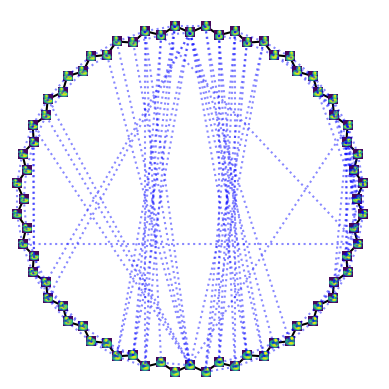

In [186]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix2[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 + 20 * (i % 2)
            scale_j = 450 + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/gmgm-less-pcs.pdf', transparent=True, dpi=200)

In [187]:
correct__2 = 0
off_by_1__2 = 0
off_by_2__2 = 0
off_by_3__2 = 0
off_by_more__2 = 0
total__2 = 0

for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix2[i, j] != 0:
            total__2 += 1
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                correct__2 += 1
            elif np.abs(i - j) == 2 or np.abs(i - j) == 70:
                off_by_1__2 += 1
            elif np.abs(i - j) == 3 or np.abs(i - j) == 69:
                off_by_2__2 += 1
            elif np.abs(i - j) == 4 or np.abs(i - j) == 68:
                off_by_3__2 += 1
            else:
                off_by_more__2 += 1
correct__2, off_by_1__2, off_by_2__2, off_by_3__2, off_by_more__2, total__2

(72, 64, 13, 0, 51, 200)

In [145]:
# Keep all edges, and postprocess for statistical significance later, so we can peek around
dataset3 = GmGM.Dataset(
    dataset={'obj1': data['obj1']}, # only one object
    structure={
        'obj1': (f'frame', f'row', f'column')
    },
    batch_axes=None
)
results3 = GmGM.GmGM(
    dataset3,
    to_keep=2 * 200/(72**2 - 72),
    threshold_method="overall",
    n_comps=10,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
)
results3

Centering...
Calculating eigenvectors...
	by calculating left eigenvectors of concatenated matricizations...
		Explained variance for axis='column': 93.4585%
		Explained variance for axis='frame': 87.3085%
		Explained variance for axis='row': 92.5049%
Calculating eigenvalues...
@0: 2217539.4505136856 (-1055.2502916908777 + 2218594.7008053763 + 0) ∆inf
Converged! (@20: 1194367.6612272903)
Recomposing sparse precisions...
Done!


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset(
	obj1: ('frame', 'row', 'column')
)
Axes(
	column: 128
		Prior: None
		Gram: Not calculated
		Eig: Calculated
	frame: 72
		Prior: None
		Gram: Not calculated
		Eig: Calculated
	row: 128
		Prior: None
		Gram: Not calculated
		Eig: Calculated
)

In [146]:
# Frame axes: d_\ℓ is 128*128, σ^γ = 1/3, NOT summed over the 20 objects
#   = sqrt(128*128) / 9 = 14.2

resmatrix3 = results3.precision_matrices['frame'].toarray()
#resmatrix3[resmatrix3 < stats.norm.ppf(1 - 0.05) / 14.2] = 0
resmatrix3

array([[0.        , 0.06410779, 0.06416554, ..., 0.        , 0.        ,
        0.06567002],
       [0.06410779, 0.        , 0.06768297, ..., 0.        , 0.        ,
        0.        ],
       [0.06416554, 0.06768297, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06567002, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

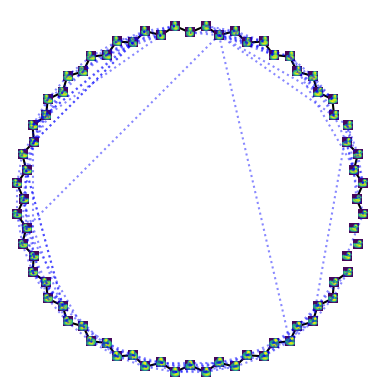

In [147]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix3[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/gmgm-one-modality.pdf', transparent=True, dpi=200)

In [148]:
correct__3 = 0
off_by_1__3 = 0
off_by_2__3 = 0
off_by_3__3 = 0
off_by_more__3 = 0
total__3 = 0

for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix3[i, j] != 0:
            total__3 += 1
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                correct__3 += 1
            elif np.abs(i - j) == 2 or np.abs(i - j) == 70:
                off_by_1__3 += 1
            elif np.abs(i - j) == 3 or np.abs(i - j) == 69:
                off_by_2__3 += 1
            elif np.abs(i - j) == 4 or np.abs(i - j) == 68:
                off_by_3__3 += 1
            else:
                off_by_more__3 += 1
correct__3, off_by_1__3, off_by_2__3, off_by_3__3, off_by_more__3, total__3

(66, 58, 44, 13, 19, 200)

In [194]:
# Keep all edges, and postprocess for statistical significance later, so we can peek around
dataset4 = GmGM.Dataset(
    dataset={'obj1': data['obj1']}, # TeraLasso only supports one object
    structure={
        'obj1': (f'frame', f'row', f'column')
    },
    batch_axes=None
)
results4 = bg.TeraLasso(
    dataset4,
    beta=5.25e-9,
    use_nonparanormal_skeptic=True,
    tol=1e-9 # exact same if tol=1e-15, so we can assume it has converged
)
results4

Dataset(
	obj1: ('frame', 'row', 'column')
)
Axes(
	column: 128
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	frame: 72
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	row: 128
		Prior: None
		Gram: Calculated
		Eig: Not calculated
)

In [195]:
# Frame axes: d_\ℓ is 128*128, σ^γ = 1/3, NOT summed over the 20 objects
#   = sqrt(128*128) / 9 = 14.2

resmatrix4 = results4.precision_matrices['frame'].toarray()
np.fill_diagonal(resmatrix4, 0)
#resmatrix4[resmatrix4 < stats.norm.ppf(1 - 0.05) / (14.2*3)] = 0
(resmatrix4 != 0).sum() / 2

197.0

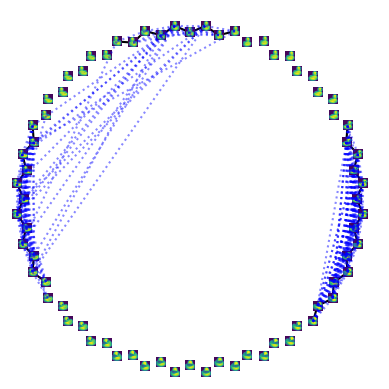

In [196]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix4[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/teralasso.pdf', transparent=True, dpi=200)

In [197]:
correct__4 = 0
off_by_1__4 = 0
off_by_2__4 = 0
off_by_3__4 = 0
off_by_more__4 = 0
total__4 = 0

for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix4[i, j] != 0:
            total__4 += 1
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                correct__4 += 1
            elif np.abs(i - j) == 2 or np.abs(i - j) == 70:
                off_by_1__4 += 1
            elif np.abs(i - j) == 3 or np.abs(i - j) == 69:
                off_by_2__4 += 1
            elif np.abs(i - j) == 4 or np.abs(i - j) == 68:
                off_by_3__4 += 1
            else:
                off_by_more__4 += 1
correct__4, off_by_1__4, off_by_2__4, off_by_3__4, off_by_more__4, total__4

(33, 31, 26, 22, 85, 197)

# Put it all together

In [198]:
def add_base(resmat: np.ndarray, ax: plt.Axes) -> None:
    ax.axis('off')

    for i in range(72):
        for j in range(72):
            if i >= j:
                continue
            if resmat[i, j] != 0:
                angle_1 = i/72 * 2 * np.pi
                angle_2 = j/72 * 2 * np.pi
                scale_i = 450 +  + 20 * (i % 2)
                scale_j = 450 +  + 20 * (j % 2)
                xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
                ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
                if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                    ax.plot(xs, ys, color='black', zorder=0)
                else:
                    ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

    for i in range(72):
        img = ax.imshow(data["obj1"][i], zorder=10)
        transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
        transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
        transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
        transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
        img.set_transform(
            transform_rot
            + transform_scale
            + transform_move
            + transform_rerot
            + ax.transData
        )

    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)

def get_offbys(resmat: np.ndarray) -> tuple[int, int, int, int, int, int]:
    correct = 0
    off_by_1 = 0
    off_by_2 = 0
    off_by_3 = 0
    off_by_more = 0
    total = 0

    for i in range(72):
        for j in range(72):
            if i >= j:
                continue
            if resmat[i, j] != 0:
                total += 1
                if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                    correct += 1
                elif np.abs(i - j) == 2 or np.abs(i - j) == 70:
                    off_by_1 += 1
                elif np.abs(i - j) == 3 or np.abs(i - j) == 69:
                    off_by_2 += 1
                elif np.abs(i - j) == 4 or np.abs(i - j) == 68:
                    off_by_3 += 1
                else:
                    off_by_more += 1
    return correct, off_by_1, off_by_2, off_by_3, off_by_more, total

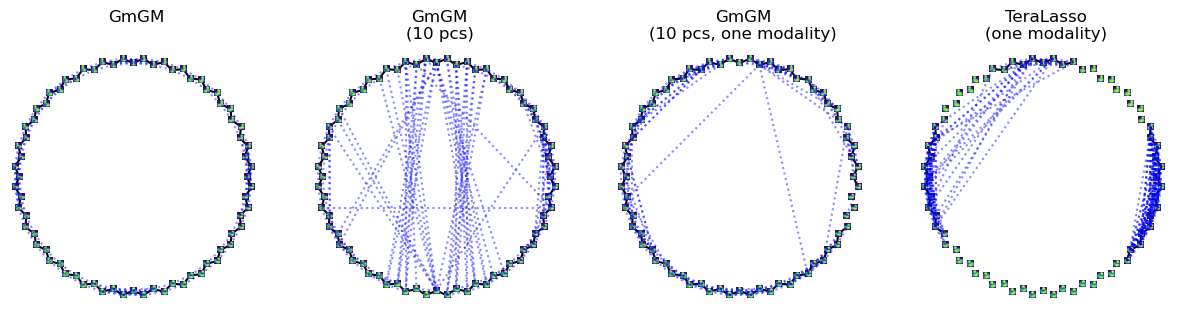

In [199]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 5))

resmatrices = [resmatrix, resmatrix2, resmatrix3, resmatrix4]
names = ["GmGM\n", "GmGM\n(10 pcs)", "GmGM\n(10 pcs, one modality)", "TeraLasso\n(one modality)"]
for ax, idx in zip(axs, range(4)):
    resmat = resmatrices[idx]
    add_base(resmat, ax)
    correct, off_by_1, off_by_2, off_by_3, off_by_more, total = get_offbys(resmatrix)
    ax.set_title(names[idx])

fig.savefig('out-figs/coil/all-methods.pdf', transparent=True, dpi=200)

# Graph connecting the videos!

In [7]:
order4_data = np.array([
    data[f'obj{i}']
    for i in range(1, 21)
])
order4_data.shape

(20, 72, 128, 128)

In [8]:
dataset5 = GmGM.Dataset(
    dataset={'all': order4_data},
    structure={
        'all': ('object', f'frame', f'row', f'column')
    },
    batch_axes=None
)

In [30]:
# Keep all edges, and postprocess for statistical significance later, so we can peek around
results5 = GmGM.GmGM(
    dataset5,
    to_keep=3,
    threshold_method="overall-col-weighted",
    n_comps=None,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
)
results5

Centering...
Calculating eigenvectors...
	by calculating gram matrices and then eigendecomposing...


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


Calculating eigenvectors for axis='column'
Calculating eigenvectors for axis='object'
Calculating eigenvectors for axis='frame'
Calculating eigenvectors for axis='row'
100% explained variance, since `n_comps` was not specified
Calculating eigenvalues...
@0: -180242859.31828117 (-180245906.29559645 + 3046.977315283597 + 0) ∆inf
Converged! (@5: -180464143.38413626)
Recomposing sparse precisions...
Done!


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset(
	all: ('object', 'frame', 'row', 'column')
)
Axes(
	column: 128
		Prior: None
		Gram: Calculated
		Eig: Calculated
	object: 20
		Prior: None
		Gram: Calculated
		Eig: Calculated
	frame: 72
		Prior: None
		Gram: Calculated
		Eig: Calculated
	row: 128
		Prior: None
		Gram: Calculated
		Eig: Calculated
)

In [31]:
resmatrix5 = results5.precision_matrices['object'].toarray()
resmatrix5

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.07610039,
        0.0997593 , 0.        , 0.        , 0.06417996, 0.        ,
        0.        , 0.        , 0.06302498, 0.        , 0.        ,
        0.        , 0.        , 0.06830194, 0.09500952, 0.06332248],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

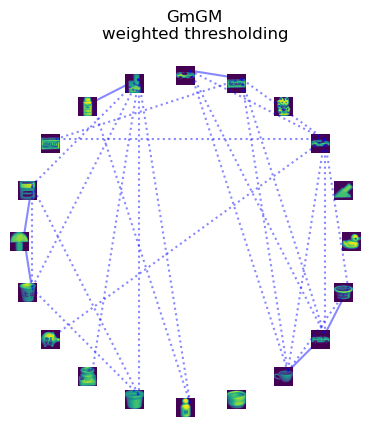

In [134]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(20):
    for j in range(20):
        if i >= j:
            continue
        if resmatrix5[i, j] != 0:
            angle_1 = i/20 * 2 * np.pi
            angle_2 = j/20 * 2 * np.pi
            scale_i = 450
            scale_j = 450
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 19:
                ax.plot(xs, ys, color='#0000ff77', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(20):
    img = ax.imshow(order4_data[i, 0], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/20 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.4, 0.4)
    transform_move = mpl.transforms.Affine2D().translate(450, 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/20 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

ax.set_title("GmGM\nweighted thresholding")

fig.savefig('out-figs/coil/all20-gmgm.pdf', transparent=True, dpi=200)

In [122]:
# Keep all edges, and postprocess for statistical significance later, so we can peek around
dataset6 = GmGM.Dataset(
    dataset={'all': order4_data / (20*72*128*128)},
    structure={
        'all': ('object', f'frame', f'row', f'column')
    },
    batch_axes=None
)
results6 = bg.TeraLasso(
    dataset6,
    beta=8.2e-7,#8.2: 56
    use_nonparanormal_skeptic=True,
    tol=1e-9
)
results6

Dataset(
	all: ('object', 'frame', 'row', 'column')
)
Axes(
	column: 128
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	object: 20
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	frame: 72
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	row: 128
		Prior: None
		Gram: Calculated
		Eig: Not calculated
)

In [124]:
x = results5.precision_matrices['object'].toarray() + results5.precision_matrices['object'].toarray().T
np.fill_diagonal(x, 0)
y = results6.precision_matrices['object'].toarray() + results6.precision_matrices['object'].toarray().T
np.fill_diagonal(y, 0)
(x != 0).sum(), (y != 0).sum()

(56, 56)

In [125]:
resmatrix6 = results6.precision_matrices['object'].toarray()
resmatrix6

array([[ 2.33639305e+01,  0.00000000e+00,  6.37760154e-05,
         0.00000000e+00,  6.80283834e-05,  0.00000000e+00,
         0.00000000e+00, -3.51158887e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.20032289e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.33673566e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.06175799e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.37760622e-05,  0.00000000e+00,  2.33631568e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

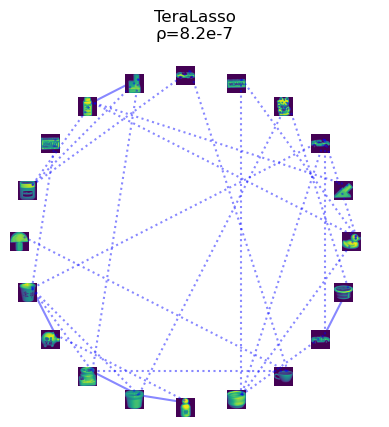

In [133]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(20):
    for j in range(20):
        if i >= j:
            continue
        if resmatrix6[i, j] != 0:
            angle_1 = i/20 * 2 * np.pi
            angle_2 = j/20 * 2 * np.pi
            scale_i = 450
            scale_j = 450
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 19:
                ax.plot(xs, ys, color='#0000ff77', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(20):
    img = ax.imshow(order4_data[i, 0], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/20 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.4, 0.4)
    transform_move = mpl.transforms.Affine2D().translate(450, 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/20 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

ax.set_title("TeraLasso\nρ=8.2e-7")

fig.savefig('out-figs/coil/all20-teralasso.pdf', transparent=True, dpi=200)

## Together

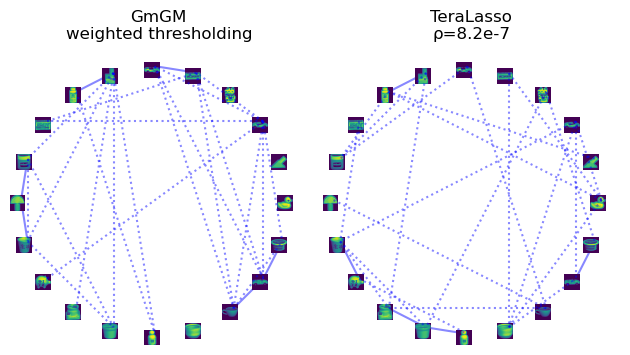

In [132]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.axis('off')
ax2.axis('off')
for i in range(20):
    for j in range(20):
        if i >= j:
            continue
        if resmatrix5[i, j] != 0:
            angle_1 = i/20 * 2 * np.pi
            angle_2 = j/20 * 2 * np.pi
            scale_i = 450
            scale_j = 450
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 19:
                ax1.plot(xs, ys, color='#0000ff77', zorder=0)
            else:
                ax1.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')
        if resmatrix6[i, j] != 0:
            angle_1 = i/20 * 2 * np.pi
            angle_2 = j/20 * 2 * np.pi
            scale_i = 450
            scale_j = 450
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 19:
                ax2.plot(xs, ys, color='#0000ff77', zorder=0)
            else:
                ax2.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(20):
    img = ax1.imshow(order4_data[i, 0], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/20 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.4, 0.4)
    transform_move = mpl.transforms.Affine2D().translate(450, 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/20 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax1.transData
    )

    img = ax2.imshow(order4_data[i, 0], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/20 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.4, 0.4)
    transform_move = mpl.transforms.Affine2D().translate(450, 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/20 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax2.transData
    )

ax1.set_xlim(-500, 500)
ax1.set_ylim(-500, 500)
ax2.set_xlim(-500, 500)
ax2.set_ylim(-500, 500)

ax1.set_title("GmGM\nweighted thresholding")
ax2.set_title("TeraLasso\nρ=8.2e-7")

fig.tight_layout()

fig.savefig('out-figs/coil/all20-all.pdf', transparent=True, dpi=200)